In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\TreasuryInflationPCA\root\src")
sys.path.append(r"/Users/diegoalvarez/Desktop/research/TreasuryInflationPCA/root/src")
from PCSpreadOLS import PCASpreadOLS

In [3]:
def _lag_resid(df: pd.DataFrame) -> pd.DataFrame: 

    df_out = (df.sort_values(
        "date").
        assign(lag_resid = lambda x: x.resid.shift()))

    return df_out

def get_backtest() -> pd.DataFrame: 

    df_raw = PCASpreadOLS().get_rolling_regression()
    df_rtn = (df_raw.assign(
        beta_calc = lambda x: x.beta * x.value).
        drop(columns = ["value", "beta"]).
        pivot(index = ["date", "security", "PX_bps", "alpha"], columns = "variable", values = "beta_calc").
        reset_index().
        assign(
            predicted = lambda x: x.alpha + x.PC1 + x.PC2 + x.PC3,
            resid     = lambda x: x.predicted - x.PX_bps).
        groupby("security").
        apply(_lag_resid, include_groups = False).
        reset_index().
        drop(columns = ["level_1"]).
        dropna().
        assign(signal_rtn = lambda x: np.sign(x.lag_resid) * x.PX_bps))

    return df_rtn

df_rtn = get_backtest()

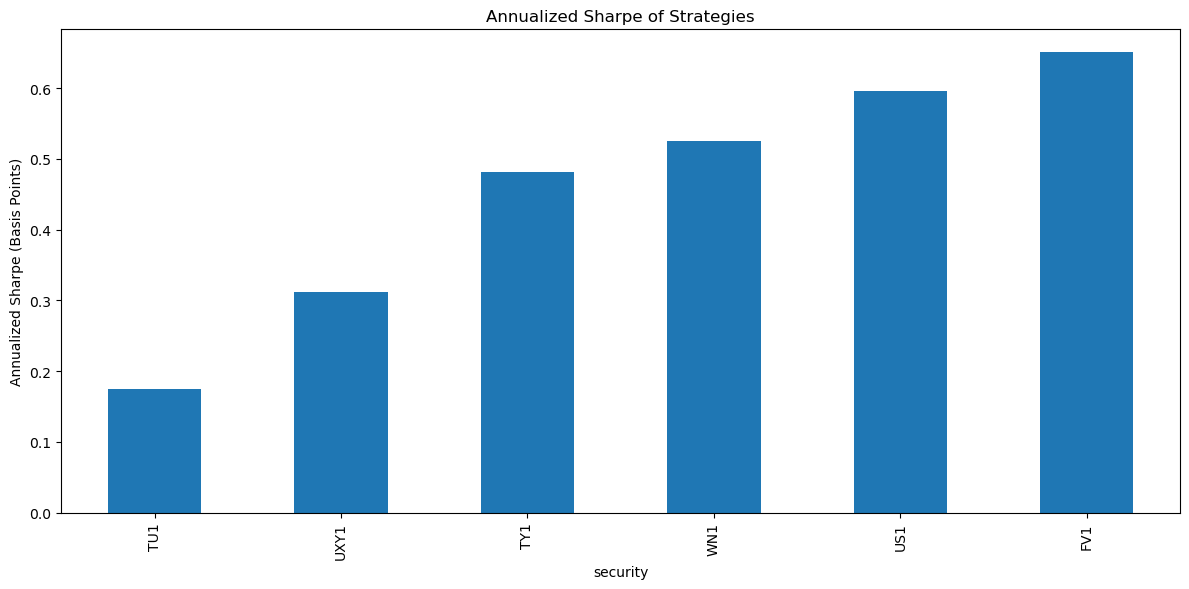

In [4]:
def plot_sharpe(df_rtn: pd.DataFrame) -> plt.Figure: 
    
    (df_rtn[
        ["security", "signal_rtn"]].
        groupby("security").
        agg(["mean", "std"])
        ["signal_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252))
        [["sharpe"]].
        sort_values("sharpe").
        plot(
            kind    = "bar",
            legend  = False,
            ylabel  = "Annualized Sharpe (Basis Points)",
            figsize = (12,6),
            title   = "Annualized Sharpe of Strategies"))
    
    plt.tight_layout()

plot_sharpe(df_rtn)

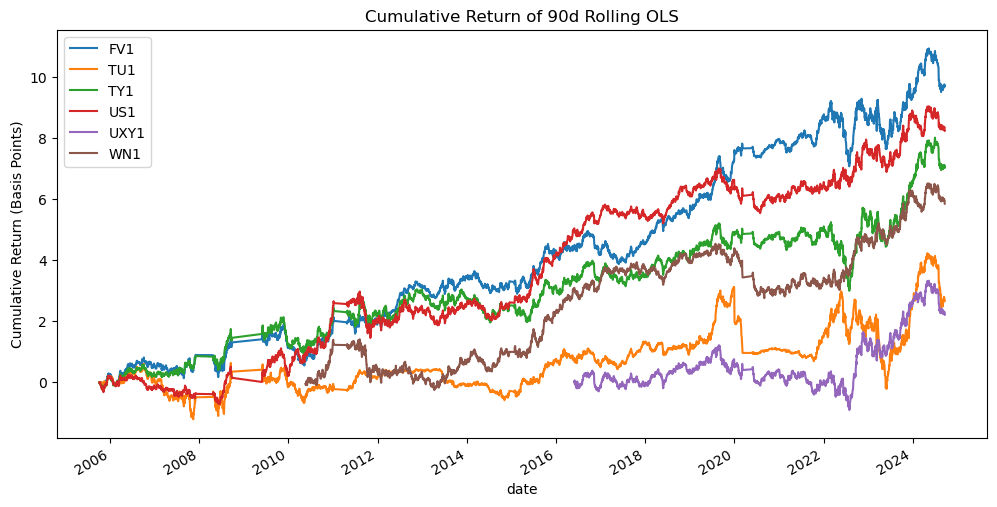

In [5]:
def plot_cum_rtn(df_rtn: pd.DataFrame) -> plt.Figure: 

    (df_rtn[
        ["date", "security", "signal_rtn"]].
        rename(columns = {"security": ""}).
        pivot(index = "date", columns = "", values = "signal_rtn").
        cumsum().
        plot(
            ylabel  = "Cumulative Return (Basis Points)",
            title   = "Cumulative Return of 90d Rolling OLS",
            figsize = (12,6)))

plot_cum_rtn(df_rtn)

In [6]:
def get_erc(df_rtn: pd.DataFrame, window: int = 30) -> pd.DataFrame: 

    df_vol = (df_rtn[
        ["date", "security", "signal_rtn"]].
        pivot(index = "date", columns = "security", values = "signal_rtn").
        ewm(span = window, adjust = False).
        std().
        shift().
        apply(lambda x: 1 / x).
        reset_index().
        melt(id_vars = "date").
        dropna().
        rename(columns = {"value": "inv_vol"}))
    
    df_out = (df_vol.drop(
        columns = ["security"]).
        groupby("date").
        agg("sum").
        rename(columns = {"inv_vol": "cum_vol"}).
        merge(right = df_vol, how = "inner", on = ["date"]).
        assign(weight = lambda x: x.inv_vol / x.cum_vol).
        merge(right = df_rtn, how = "inner", on = ["date", "security"]).
        assign(weighted_rtn = lambda x: x.weight * x.signal_rtn)
        [["date", "weighted_rtn"]])

    return df_out

df_erc = get_erc(df_rtn)

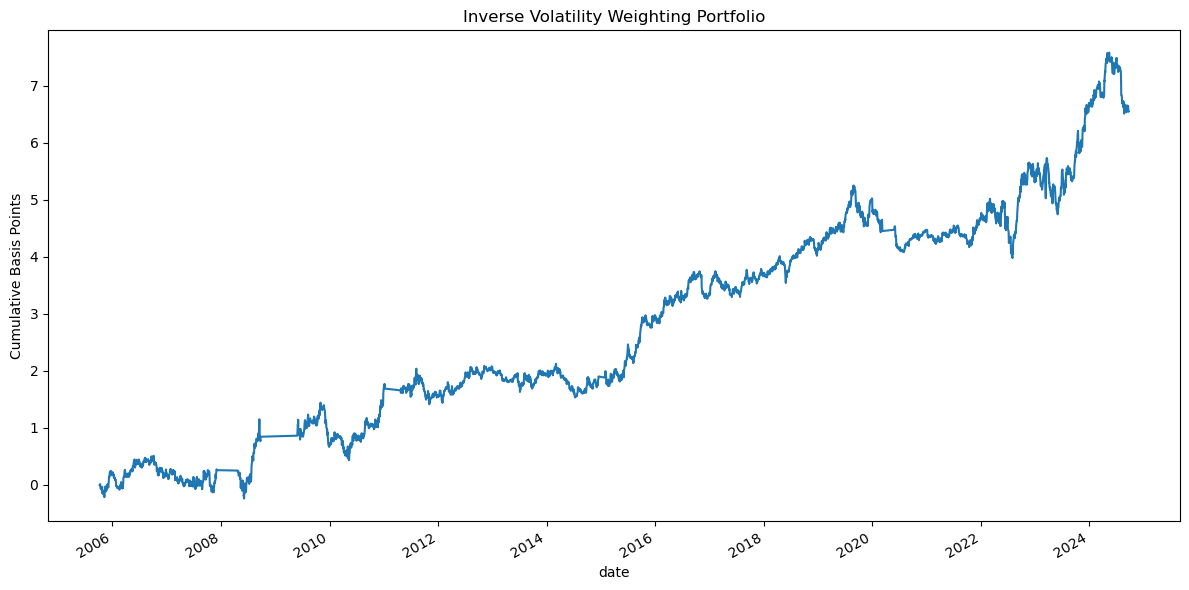

In [7]:
def plot_erc_return(df_erc: pd.DataFrame) -> plt.Figure: 

    (df_erc[
        ["date", "weighted_rtn"]].
        groupby("date").
        agg("sum").
        sort_index().
        cumsum().
        plot(
            legend  = False,
            title   = "Inverse Volatility Weighting Portfolio",
            ylabel  = "Cumulative Basis Points",
            figsize = (12,6)))
    
    plt.tight_layout()

plot_erc_return(df_erc)

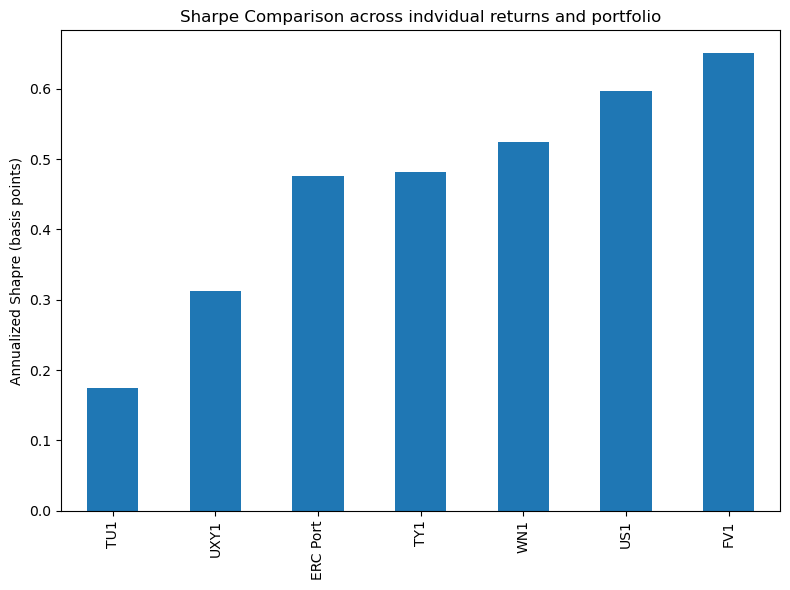

In [8]:
def plot_all_sharpe(df_erc: pd.DataFrame, df_rtn: pd.DataFrame) -> plt.Figure:

    strat_sharpe = (df_erc[
        ["weighted_rtn"]].
        agg(["mean", "std"]).
        T.
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252))
        [["sharpe"]].
        rename(index = {"weighted_rtn": "ERC Port"}))
    
    df_strat = (df_rtn[
        ["security", "signal_rtn"]].
        groupby("security").
        agg(["mean", "std"])
        ["signal_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252))
        [["sharpe"]])
    
    (pd.concat(
        [df_strat, strat_sharpe]).
        sort_values("sharpe").
        plot(
            ylabel  = "Annualized Shapre (basis points)",
            kind    = "bar",
            legend  = False,
            title   = "Sharpe Comparison across indvidual returns and portfolio",
            figsize = (8,6)))

    plt.tight_layout()

plot_all_sharpe(df_erc, df_rtn)